# NOAA National Digital Forecast Database
https://registry.opendata.aws/noaa-ndfd/

The National Digital Forecast Database (NDFD) is a suite of gridded forecasts of sensible weather elements (e.g., cloud cover, maximum temperature). Forecasts prepared by NWS field offices working in collaboration with the National Centers for Environmental Prediction (NCEP) are combined in the NDFD to create a seamless mosaic of digital forecasts from which operational NWS products are generated. The most recent data is under the opnl and expr prefixes.

Some useful info on the NDFD and GRIB file format can be found here.

After working with the GRIB data I found that there is a REST API that returns xml data for a single point and that may be an option if the gridded data turns out to be unnecessary (https://graphical.weather.gov/xml/rest.php)

This notebook is to demonstrate how to extract data from the GRIB files in a useful way. There is an excellent [series on Metpy Monday](https://www.unidata.ucar.edu/blogs/developer/entry/metpy-mondays-135-reading-grib) with some useful context on working with GRIB files. I also got some very helpful pointers from @dopplershift on the software underground.

## Now the Code
All of these functions are broken down step by step below.

In [1]:
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pygrib

from pyproj import CRS
from pyproj import Transformer

def create_grb_projection(grb):
    
    # grid definition
    radius = grb.radius
    central_lat = grb.LaDInDegrees
    central_lon = grb.LoVInDegrees
    first_secant_lat = grb.Latin1InDegrees
    second_secant_lat = grb.Latin2InDegrees
    
    # Set up the projection information
    globe = ccrs.Globe(semimajor_axis=radius)
    data_proj = ccrs.LambertConformal(globe=globe, central_latitude=central_lat,
                                      central_longitude=central_lon,
                                      standard_parallels=(first_secant_lat, second_secant_lat))
    return data_proj


def lon_lat_to_grid_coords(lon, lat, data_proj):
    x, y = data_proj.transform_point(lon,
                                     lat,
                                     src_crs=ccrs.PlateCarree())
    return x, y


def grb_to_da(grb):
    
    # data
    values = grb.values[np.newaxis, ...]
    t = np.array(grb.validDate)[..., np.newaxis]
    analysis_date = grb.analDate
    parameter = grb.parameterName
    unit = grb.parameterUnits
    
    # grid definition
    first_grid_point_lon = grb.longitudeOfFirstGridPointInDegrees
    first_grid_point_lat = grb.latitudeOfFirstGridPointInDegrees
    
    nx = grb.Nx
    ny = grb.Ny
    dx = grb.DxInMetres
    dy = grb.DyInMetres
    
    
    # define the cartopy crs for the projection
    data_proj = create_grb_projection(grb)
    
    # Transform the corner point lat/lon to an x/y in the projected coordinates
    x0, y0 = lon_lat_to_grid_coords(first_grid_point_lon, 
                                    first_grid_point_lat,
                                    data_proj)
    
    # Generate the grid x/y from that corner using the number of point and the spacing
    x = x0 + np.arange(nx) * dx
    y = y0 + np.arange(ny) * dy
    

    # create x array data array
    da = xr.DataArray(data=values,
                  dims=["time", "y", "x"],
                  coords=dict(
                      x=x,
                      y=y,
                      time=t
                      ),
                  attrs=dict(
                      paramter=parameter,
                      unit=unit,
                      analysis_date=analysis_date,
                      crs_wkt=data_proj.to_wkt()
                      )
                 )
    
    return da


def create_forecast_cube(grbs):
    """iterate through grb messages in a grib file, 
        create data arrays for each timestamp, 
        and concatenate them togeher into a 3D data array"""
    arrays = list()

    for grb in grbs:
        da = grb_to_da(grb)
        arrays.append(da)

    forecast_cube = xr.concat(arrays, dim="time")
    return forecast_cube

# https://vlab.noaa.gov/web/mdl/ndfd-grid-data
# https://vlab.noaa.gov/web/mdl/ndfd-grib-all-sections

In [2]:
# download the forecast grib file
!wget 'https://noaa-ndfd-pds.s3.amazonaws.com/opnl/AR.conus/VP.001-003/ds.temp.bin' -O forecast.bin

--2022-03-16 21:38:34--  https://noaa-ndfd-pds.s3.amazonaws.com/opnl/AR.conus/VP.001-003/ds.temp.bin
Resolving noaa-ndfd-pds.s3.amazonaws.com (noaa-ndfd-pds.s3.amazonaws.com)... 52.216.168.171
Connecting to noaa-ndfd-pds.s3.amazonaws.com (noaa-ndfd-pds.s3.amazonaws.com)|52.216.168.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47696099 (45M) [application/octet-stream]
Saving to: ‘forecast.bin’

forecast.bin        100%[===================>]  45.49M  4.52MB/s    in 18s     

2022-03-16 21:38:53 (2.54 MB/s) - ‘forecast.bin’ saved [47696099/47696099]



You will see that the GRIB file is divided into a sequence of messages. Each message consists of a 2d spatial grid that contains the forecast at a given time in the future from the analysis date. Below, I am printing out the first 5 messages in the file

In [3]:
grbs = pygrib.open('forecast.bin')
grbs.seek(0)
for grb in grbs[1:6]:
    print(grb)

1:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 30 mins:from 202203170330
2:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 90 mins:from 202203170330
3:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 150 mins:from 202203170330
4:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 210 mins:from 202203170330
5:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 270 mins:from 202203170330


We can grab the first grb message (yes, the messages are 1 indexed!) and plot the values. Notice that this "map" is unprojected, and the x and y axes represent the integer index of the grid

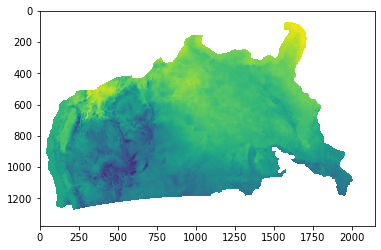

In [4]:
grb = grbs[1]
values = grb.values
plt.imshow(values)

In order to reproject the data, I need to construct the definition of the coordinate reference system from the data contained in the grb message. Cartopy provides a convenient interface for constructing a crs from these parameters.

In [5]:
radius = grb.radius
central_lat = grb.LaDInDegrees
central_lon = grb.LoVInDegrees
first_secant_lat = grb.Latin1InDegrees
second_secant_lat = grb.Latin2InDegrees

# Set up the projection information
globe = ccrs.Globe(semimajor_axis=radius)
data_proj = ccrs.LambertConformal(globe=globe, central_latitude=central_lat,
                                  central_longitude=central_lon,
                                  standard_parallels=(first_secant_lat, second_secant_lat))

data_proj

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +a=6371200.0 +lon_0=265.0 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

Now I can use this CRS to transform lat lons into the x, y of the Lambert Conformal Projection

In [6]:
lon = -104.848
lat = 39.560

x, y = data_proj.transform_point(lon,
                                 lat,
                                 src_crs=ccrs.PlateCarree())

x, y

(-873830.0532782322, 1662764.8688734733)

Now, I can use all of this information to transform the grid indexes in the above "map" into the proper crs x, y coordinates.

In [7]:
# grid definition
first_grid_point_lon = grb.longitudeOfFirstGridPointInDegrees
first_grid_point_lat = grb.latitudeOfFirstGridPointInDegrees

nx = grb.Nx
ny = grb.Ny
dx = grb.DxInMetres
dy = grb.DyInMetres

# Transform the corner point lat/lon to an x/y in the projected coordinates
x0, y0 = data_proj.transform_point(first_grid_point_lon, 
                                   first_grid_point_lat,
                                   src_crs=ccrs.PlateCarree())

# Generate the grid x/y from that corner using the number of point and the spacing
x = x0 + np.arange(nx) * dx
y = y0 + np.arange(ny) * dy

x, y

(array([-2764251.52997483, -2761711.82697483, -2759172.12397483, ...,
         2675792.29602517,  2678331.99902517,  2680871.70202517]),
 array([-260891.10816169, -258351.40516169, -255811.70216169, ...,
        3228660.81383831, 3231200.51683831, 3233740.21983831]))

Now I can put this into an xarray data array. Along with some other parameters. Note I am storing the projection informaiton as WKT, so it can be read back later for transforming lat lons into the native xy's.

In [8]:
# grid definition
values = grb.values[np.newaxis, ...]
t = np.array(grb.validDate)[..., np.newaxis]
analysis_date = grb.analDate
parameter = grb.parameterName
unit = grb.parameterUnits

da = xr.DataArray(data=values,
                  dims=["time", "y", "x"],
                  coords=dict(
                      x=x,
                      y=y,
                      time=t
                      ),
                  attrs=dict(
                      paramter=parameter,
                      unit=unit,
                      analysis_date=analysis_date,
                      crs_wkt=data_proj.to_wkt()
                      )
                 )

da

<xarray.DataArray (time: 1, y: 1377, x: 2145)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x        (x) float64 -2.764e+06 -2.762e+06 ... 2.678e+06 2.681e+06
  * y        (y) float64 -2.609e+05 -2.584e+05 ... 3.231e+06 3.234e+06
  * time     (time) datetime64[ns] 2022-03-17T04:00:00
Attributes:
    paramter:       Temperature
    unit:           K
    analysis_date:  2022-03-17 03:30:00
    crs_wkt:        PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...

Now I can use x array to plot the data in the projected crs

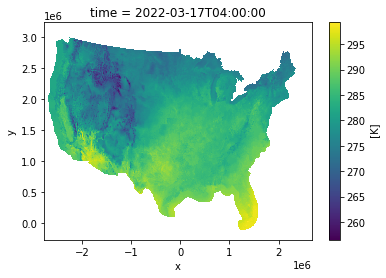

In [9]:
da.plot()

Loop through all of the grb messages, create a dataarray for each one, and concatenate them together along the time axis to create a 3D cube. 

In [10]:
arrays = list()
grbs.seek(0)
for grb in grbs:
    da = grb_to_da(grb)
    arrays.append(da)

forecast_cube = xr.concat(arrays, dim="time")

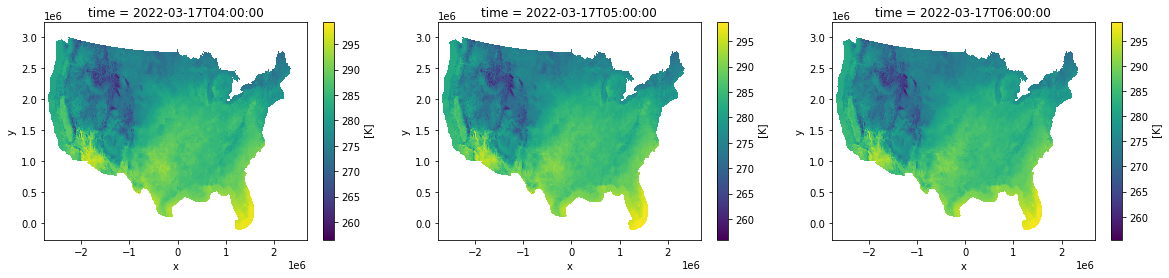

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))
for i, ax in enumerate(axes):
    forecast_cube.isel(time=i).plot(ax=ax)

I can use pyproj and the wkt from the attributes of the cube to reconstruct the crs, transform lat lons into the data crs, and extract a time series of production from that location. 

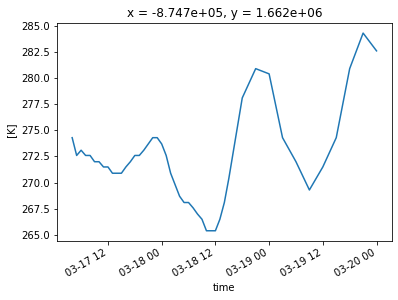

In [12]:
data_crs = CRS.from_wkt(forecast_cube.crs_wkt)
crs_4326 = CRS.from_epsg(4326)

t = Transformer.from_crs(crs_4326, data_crs, always_xy=True)
x, y = t.transform(-104.848, 39.560)

forecast_cube.sel(x=x, y=y, method='nearest').plot()

In [13]:
forecast_cube.shape

(47, 1377, 2145)

## Scratch workspace / notes below

In [14]:
grb.keys()

['globalDomain',
 'GRIBEditionNumber',
 'tablesVersionLatestOfficial',
 'tablesVersionLatest',
 'grib2divider',
 'angleSubdivisions',
 'missingValue',
 'ieeeFloats',
 'isHindcast',
 'section0Length',
 'identifier',
 'discipline',
 'editionNumber',
 'totalLength',
 'sectionNumber',
 'section1Length',
 'numberOfSection',
 'centre',
 'centreDescription',
 'subCentre',
 'tablesVersion',
 'masterDir',
 'localTablesVersion',
 'significanceOfReferenceTime',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'dataDate',
 'julianDay',
 'dataTime',
 'productionStatusOfProcessedData',
 'typeOfProcessedData',
 'md5Section1',
 'selectStepTemplateInterval',
 'selectStepTemplateInstant',
 'stepType',
 'is_chemical',
 'is_chemical_distfn',
 'is_chemical_srcsink',
 'is_aerosol',
 'is_aerosol_optical',
 'setCalendarId',
 'deleteCalendarId',
 'sectionNumber',
 'grib2LocalSectionPresent',
 'deleteLocalDefinition',
 'sectionNumber',
 'gridDescriptionSectionPresent',
 'section3Length',
 'numberOfSec

In [15]:
grb.parameterUnits

'K'

In [16]:
grb.parameterName

'Temperature'

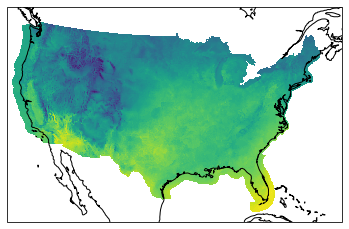

In [17]:
#code from @dopplershift

import matplotlib.pyplot as plt
import pygrib

# Open grib and get the first message
grbs = pygrib.open('forecast.bin')
msg = grbs[1]

# Set up the projection information
globe = ccrs.Globe(semimajor_axis=msg['radius'])
data_proj = ccrs.LambertConformal(globe=globe, central_latitude=msg['LaDInDegrees'],
                                  central_longitude=msg['LoVInDegrees'],
                                  standard_parallels=(msg['Latin1InDegrees'], msg['Latin2InDegrees']))

# Transform the corner point lat/lon to an x/y in the projected coordinates
x0, y0 = data_proj.transform_point(msg['longitudeOfFirstGridPointInDegrees'],
                                   msg['latitudeOfFirstGridPointInDegrees'],
                                   src_crs=ccrs.PlateCarree())

# Generate the grid x/y from that corner using the number of point and the spacing
x = x0 + np.arange(msg['Nx']) * msg['DxInMetres']
y = y0 + np.arange(msg['Ny']) * msg['DyInMetres']

# Plot on a map to verify we got this right
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=data_proj)
ax.pcolormesh(x, y, msg.values)
ax.coastlines()

In [18]:
print('radius of earth:', msg.radius)
print('LaDInDegrees: ', msg.LaDInDegrees)
print('LoVInDegrees: ', msg.LoVInDegrees)
print('Latin1InDegrees', msg.Latin1InDegrees)
print('Latin2InDegrees', msg.Latin2InDegrees)
print('longitudeOfFirstGridPointInDegrees:', msg.longitudeOfFirstGridPointInDegrees)
print('latitudeOfFirstGridPointInDegrees:', msg.latitudeOfFirstGridPointInDegrees)
print('Nx:', msg.Nx)
print('Ny:', msg.Ny)
print('DxInMetres:', msg.DxInMetres)
print('DyInMetres:', msg.DyInMetres)#, msg.LaDInDegrees, msg.LoVInDegrees, msg.radius

radius of earth: 6371200.0
LaDInDegrees:  25.0
LoVInDegrees:  265.0
Latin1InDegrees 25.0
Latin2InDegrees 25.0
longitudeOfFirstGridPointInDegrees: 238.445999
latitudeOfFirstGridPointInDegrees: 20.191999
Nx: 2145
Ny: 1377
DxInMetres: 2539.703
DyInMetres: 2539.703


In [19]:
x, y

(array([-2764251.52997483, -2761711.82697483, -2759172.12397483, ...,
         2675792.29602517,  2678331.99902517,  2680871.70202517]),
 array([-260891.10816169, -258351.40516169, -255811.70216169, ...,
        3228660.81383831, 3231200.51683831, 3233740.21983831]))

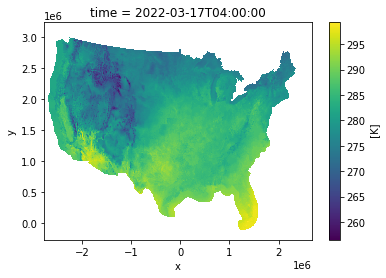

In [20]:
grb = grbs[1]

values = grb.values[np.newaxis, ...]
lat, lon = grb.latlons()
t = np.array(grb.validDate)[..., np.newaxis]
analysis_date = grb.analDate
parameter = grb.parameterName
unit = grb.parameterUnits

da = xr.DataArray(data=values,
              dims=["time", "y", "x"],
              coords=dict(
                  x=x,
                  y=y,
                  time=t
                  ),
              attrs=dict(
                  paramter=parameter,
                  unit=unit,
                  analysis_date=analysis_date)
             )
da.plot()

In [21]:
x, y = data_proj.transform_point(-104.8, 39.5,
                                   src_crs=ccrs.PlateCarree())
x, y

(-870075.4806080422, 1655591.1780763748)

In [22]:
da.sel(x=x, y=y, method='nearest')

<xarray.DataArray (time: 1)>
array([274.3])
Coordinates:
    x        float64 -8.696e+05
    y        float64 1.657e+06
  * time     (time) datetime64[ns] 2022-03-17T04:00:00
Attributes:
    paramter:       Temperature
    unit:           K
    analysis_date:  2022-03-17 03:30:00

In [23]:
import pyproj

In [24]:
from pyproj import CRS
from pyproj import Transformer
data_crs = CRS.from_wkt(forecast_cube.crs_wkt)
crs_4326 = CRS.from_epsg(4326)

t = Transformer.from_crs(crs_4326, data_crs, always_xy=True)
t.transform(-104.848, 39.560)

(-873830.0532781974, 1662764.868873452)

In [25]:
data_crs

<Derived Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unk ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich